In [178]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib as mpl

L, W = 80, 80 # lattice size.
G = nx.grid_2d_graph(L, W)
G_positions = G.nodes() # original node labels can be used as "coordinates"

## Explanation

So we are trying to relabel the nodes so that the left edge is first, then the bottom edge.

For example, for a 4x3 graph the order should be

$$\begin{matrix}
3 & 8 & 10 & 12 \\
2 & 7 & 9 & 11 \\
1 & 4 & 5 & 6
\end{matrix}
$$

so the new labels should be in this order: 1, 2, 3, 4, 7, 8, 5, 9, 10, 6, 11, 12.

---------------------------

What we will do is use `nx.relabel_nodes`. It takes the graph and a dictionary `d` which should map from the old label to the new label. We will store the old labels in `a`, and create a list `b` which holds the new labels in order.

We do this by setting `b=[1, 2, ..., W]`, and creating two lists 'b', `b1` and `b2`:
- b = $[1, 2, ..., W]$   (the nodes on the left edge, corresponding to V = 1)
- b1 = $[W+1, ..., W+L-1]$   (the nodes on the bottom edge, corresponding to V = 0).
- b2 = the rest (the nodes with unknown potential).

In the above case, `b1` = $[4, 5, 6],$ `b2` = $[7, 8, 9, 10, 11, 12]$

Then we concatenate the three arrays into a single b, arranged by the sequence of the nodes (b - b1 - b2) using vstack and hstack.

Finally create the desired dictionary `d` from a and b by doing `d=dict(zip(a, b))`.

In [179]:
a = list(G.nodes)

b = np.arange(1, W+1).reshape(W, 1) # left edge
b1 = np.arange(W+1, W+L).reshape(L-1, 1) # bottom edge
b2 = np.array([list(range((W-1)*i + L+1, (W-1)*(i+1) + L+1)) for i in range(1, L)])

b = list(np.vstack((b, np.hstack((b1,b2)).reshape(L*W-W,1))).flat)
d = dict(zip(a,b))
G = nx.relabel_nodes(G,d)

# Position
pos = dict(zip(b, G_positions))

# nx.draw(G, with_labels=True, node_size=1000, pos=pos)

In [180]:
# Laplacian matrix
K = nx.linalg.laplacianmatrix.laplacian_matrix(G, nodelist=list(range(1, L*W+1))).toarray()

We know that $Kx=f$ where $K$ is the Laplacian and $f$ is the net current out of a node. We will assume that Kirchoff's current law holds at all nodes except the source and sink nodes, so $f=0$ at these nodes.

However we have reordered the nodes such that the first $W$ nodes have $\phi=1$ and the next $L-1$ nodes have $\phi=0$. By decomposing the Laplacian into four parts, we can rewrite the equation as

$\begin{pmatrix} A & B^T \\ B & C \end{pmatrix} \begin{pmatrix} v \\ \textbf{x} \end{pmatrix}= \begin{pmatrix}f  \\ 0 \end{pmatrix}$

where

- the first matrix is the decomposition of the Laplacian
- $v$ is a vector with $W$ 1's and $L-1$ 0's (potentials at the boundary)
- $x$ is the vector of potentials we want to calculate
- $f$ is the net current out of the boundary nodes. 

We can use the second row of this matrix equation to deduce that $\textbf{x}=-C^{-1}Bv$.


In [181]:
# constructing v, extracting B, C and solving for x
v = np.array([1]*W + [0]*(L-1))
B = K[-(W-1)*(L-1):, :W+L-1]
C = K[-(W-1)*(L-1):, -(W-1)*(L-1):]

x = (-np.linalg.inv(C) @ B @ v).flatten()

potentials = np.round(np.concatenate([v, x]),2)
potentials

array([1. , 1. , 1. , ..., 0.5, 0.5, 0.5])

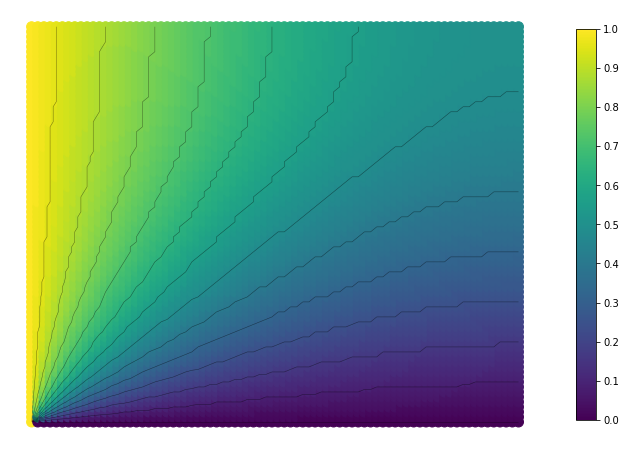

In [187]:
# Make a list of the potentials, in the new order (for coloring the nodes)
potentials_ordered = [potentials[i-1] for i in b]

# Make the node labels the potentials.
labels = dict(zip(range(1, L*W + 1), potentials))
nx.relabel_nodes(G, labels)

cmap = 'viridis'

fig, ax = plt.subplots(figsize=(12,8))

# Draw
fig = nx.draw(G,node_size=100, pos=pos, with_labels=False, labels=labels, cmap=cmap, node_color = potentials_ordered, ax=ax)


# Contours
data = np.reshape(potentials_ordered, (L, W)).T
ax.contour(data, levels=15, colors='black', alpha=0.5, linewidths=0.5)


# Colorbar
# Source: https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,1,11), shrink=0.9, ax=ax)

plt.show()

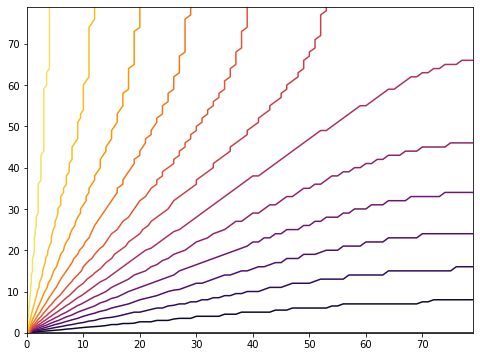

In [190]:
data = np.reshape(potentials_ordered, (L, W)).T
plt.figure(figsize=(8,6))
plt.contour(data, levels=15, cmap='inferno')
plt.show()